In [1]:
import os
import sys
import numpy as np

sys.path.append("../vsegmenter")

from vsegmenter import cfg
from vsegmenter.data import dataset
import random
from matplotlib import pyplot as plt
import tensorflow as tf


In [2]:
dataset_file = cfg.resource("dataset/v1_128.pickle")
dts = dataset.load_dataset(dataset_file)
train_dts, test_dts = dts["train"], dts["test"]
x_train, y_train = train_dts
x_test, y_test = test_dts
print(f"Number of train samples: {len(x_train)}, test samples = {len(x_test)}")
print(f"Sample dimensions: sample: {x_train[0].shape} label (mask): {y_train[0].shape}")
print("Original image shape : {}".format(x_train.shape))

Number of train samples: 400, test samples = 100
Sample dimensions: sample: (128, 128, 3) label (mask): (128, 128, 1)
Original image shape : (400, 128, 128, 3)


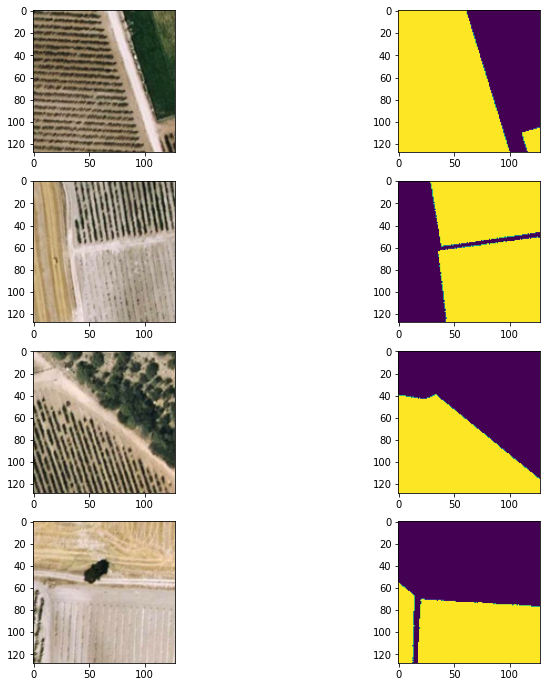

In [3]:
import random

fig = plt.figure(figsize=(12, 12))
rows = 4
columns = 2
c = random.randrange(0, 200)
counter = 0
for i in range(1, (rows * columns) + 1):
    fig.add_subplot(rows, columns, i)
    if counter % 2 == 0:
        plt.imshow(tf.keras.utils.array_to_img(x_train[c]))
        # plt.imshow(tf.keras.utils.array_to_img(x_train[c]))
    else:
        plt.imshow(y_train[c][:, :, 0])
        c = c + 1
    counter = counter + 1

In [12]:
from model.unet_tf import unet_model

OUTPUT_CLASSES = 1

model = unet_model(output_channels=OUTPUT_CLASSES, train_encoder=True, final_activation="softmax")
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
# model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_3[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [28]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def create_binary(pred_mask):
    pred = np.where(pred_mask > 0, 1, 0)
    return pred_mask

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


Check the prediction before training


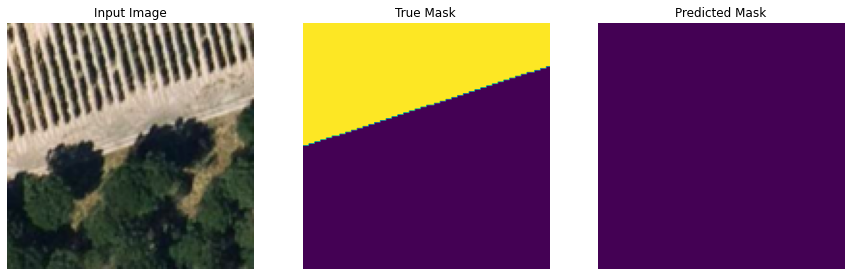

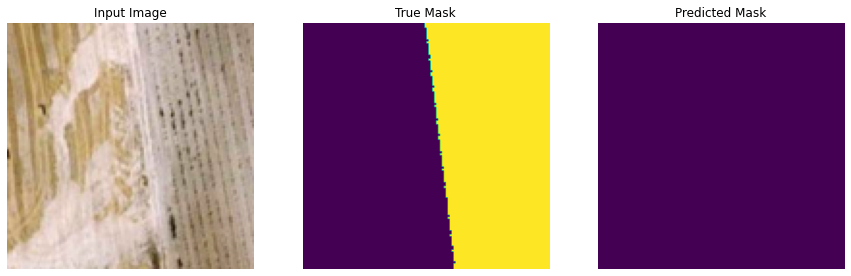

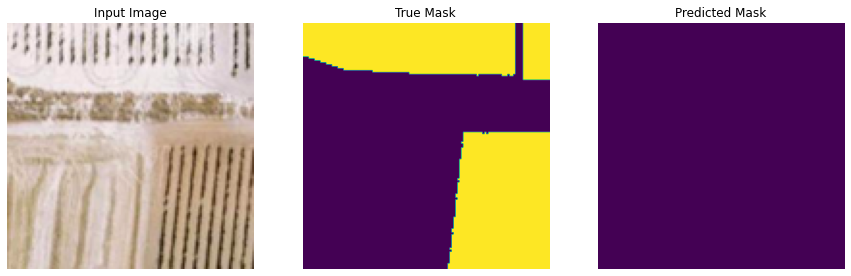

In [29]:
print("Check the prediction before training")


def show_predictions(num_preds=10):
    for i in range(num_preds):
        idx = random.randrange(0, len(x_test))
        im1 = x_test[idx]
        mask1 = y_test[idx]
#         y_pred = create_mask(model.predict(im1[tf.newaxis, ...]))
        y_pred = create_binary(model.predict(im1[tf.newaxis, ...])[0])

        display((im1, mask1, y_pred))


show_predictions(3)
# for image, mask in zip(x_test,y_test):
#     print(mask.shape)

In [13]:
from model.train import create_generators

EPOCHS = 5
VAL_SUBSPLITS = 2
BATCH_SIZE = 64
info = dts["info"]
# num_examples =

train_generator, validation_generator = create_generators(x_train, y_train, x_test, y_test, batch_size=BATCH_SIZE)

train_steps = len(x_train) // BATCH_SIZE
val_steps = len(x_test) // BATCH_SIZE # // VAL_SUBSPLITS
history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=EPOCHS,
                    validation_data=validation_generator, validation_steps=val_steps)

Epoch 1/5
6/6 [==============================] - 19s 3s/step - loss: 0.4975 - accuracy: 0.0000e+00 - val_loss: 0.1351 - val_accuracy: 0.0000e+00
Epoch 2/5
6/6 [==============================] - 14s 3s/step - loss: 0.1110 - accuracy: 0.0000e+00 - val_loss: 0.0435 - val_accuracy: 0.0000e+00
Epoch 3/5
6/6 [==============================] - 14s 2s/step - loss: 0.0477 - accuracy: 0.0000e+00 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 4/5
6/6 [==============================] - 13s 2s/step - loss: 0.0287 - accuracy: 0.0000e+00 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 5/5
6/6 [==============================] - 13s 2s/step - loss: 0.0225 - accuracy: 0.0000e+00 - val_loss: 0.0173 - val_accuracy: 0.0000e+00


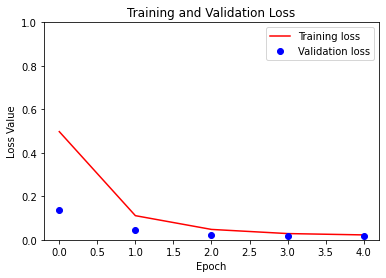

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [33]:
idx = random.randrange(0, len(x_train))
im = x_train[idx]
mask = y_train[idx]
y_pred = model.predict(im[tf.newaxis, ...])

create_binary_mask(y_pred[0])

# np.histogram(y_pred)
# plt.imshow(im1)
# np.histogram(y_pred)


NameError: name 'create_binary_mask' is not defined

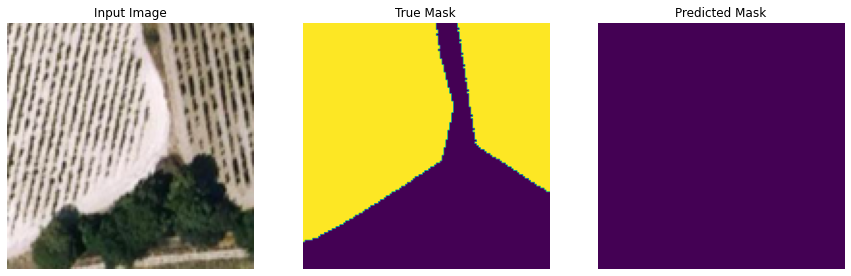

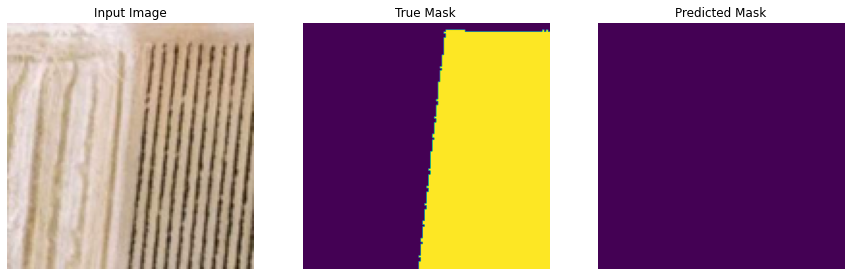

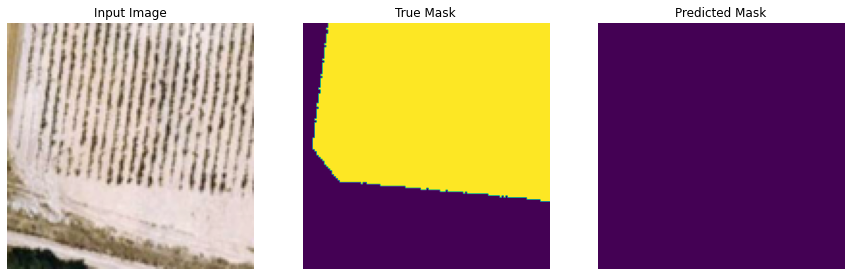

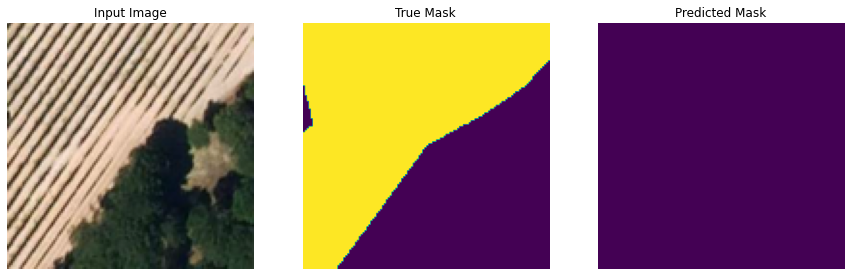

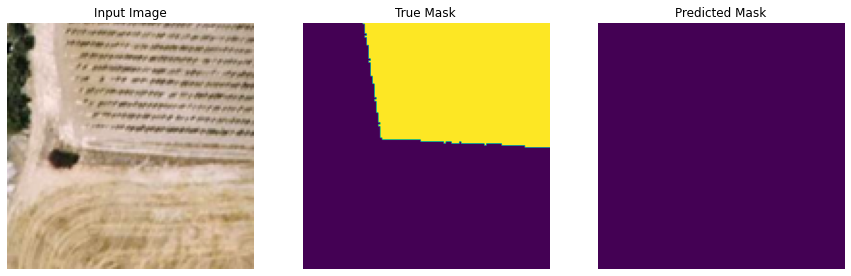

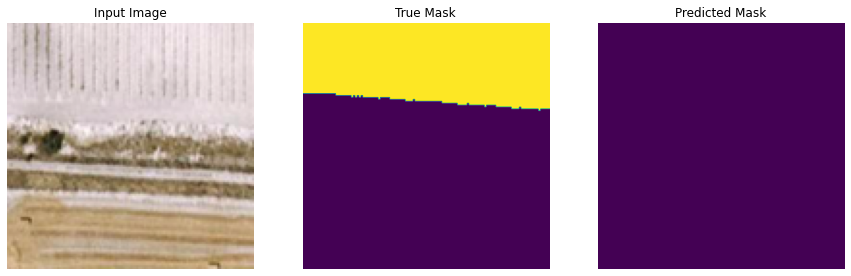

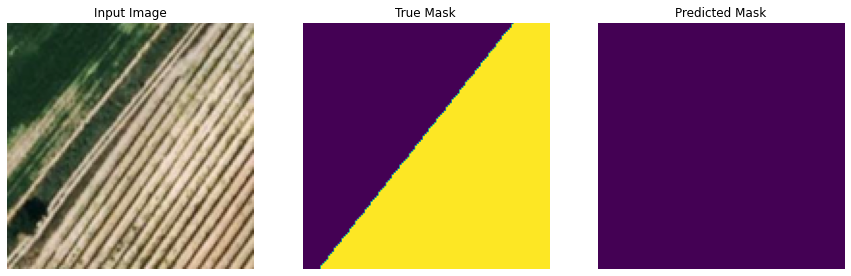

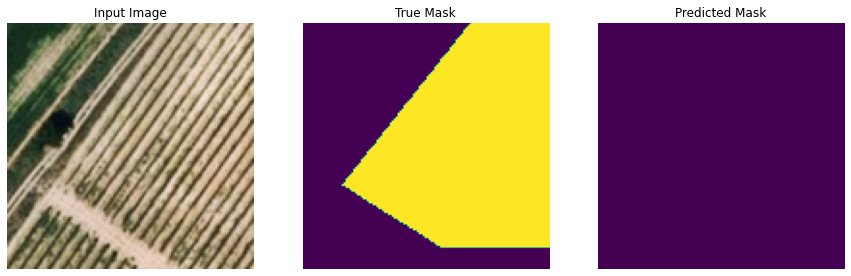

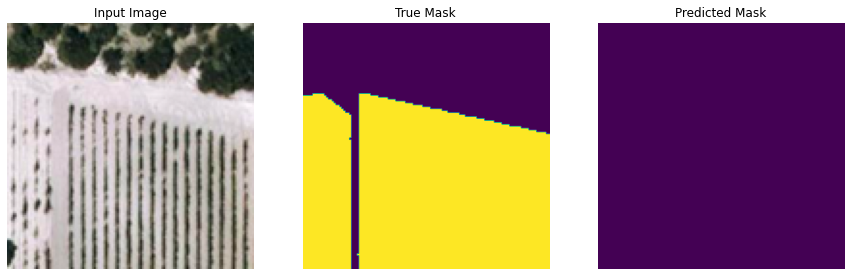

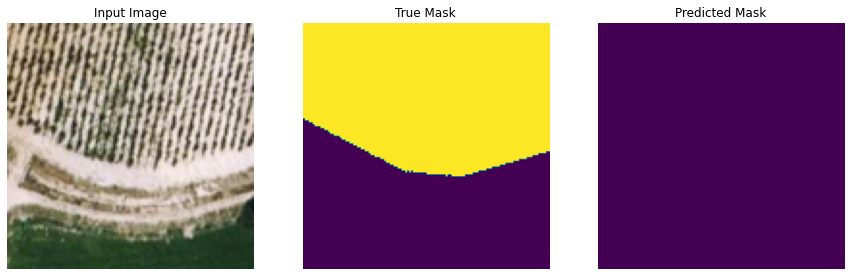

In [31]:
show_predictions(10)